Importing Libraries:
==

In [17]:
%matplotlib inline

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses


import torch
import torch.nn as nn
from torch import optim
from torch.utils import data
from torchvision.transforms import functional as F
import torchvision
import shutil

from sklearn.metrics import jaccard_score as jsc

from PIL import Image
from matplotlib.path import Path
import os
import pandas as pd

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    #torch.set_default_tensor_type('torch.cuda.FloatTensor') (else HPC doesn't work)
else:
    print('GPU is not available!')
    device = "cpu"

GPU is not available!


Hyperparams:
==

In [18]:
# depth of UNet = 3
learning_rate = 1e-5
epoch_number = 250
batch_size = 16 # make it 2-4 once bug fixing is over
train_size = 100 # divide train:val by 70:30 probably
test_size = 25 # if we break the super test image into individual images to run our model on
img_size = 768 # dimensions to resize input 750x750 into (power of 2^(depth+\delta) necessary for model to work)
max_channels = 512 # gives error if divided by 2 {or more}, not technically max_channel... number of channels after first conv is max_channels / 2^4
gradient_clip = 50 # tried 10 and 100 too   
dice_alpha = 1e-3 # maybe try 1e-4 and 1.0
pretrained = True
freeze_layers = 0 # for pretrained model
name = 'test'
PATH = os.path.join(os.getcwd(),'models/',name+'.pt')
bestPATH = os.path.join(os.getcwd(),'models/best_model_'+name+'.pt')

Loading Data:
==

In [19]:
def transform(x):
    return  torchvision.transforms.functional.to_tensor(x)

class DataSet(torch.utils.data.Dataset):
    def float_maker(self, a):
        if a[0]=='(':
            return a[1:]
        if a[-1]==')':
            return a[:-1]
        return a
    def __init__(self, mode):
        super().__init__()
        self.image_names= os.listdir('./Data_ML/image_chips/')
        self.mode = mode
        # self.image_names= os.listdir('/content/drive/MyDrive/Data_ML/image_chips/') for google.colab
    def __getitem__(self, index):
        if(self.mode == 'Train'):
            image = plt.imread(os.path.join(os.getcwd(),'Data_ML','image_chips',self.image_names[index]))
            mask = pd.read_csv(os.path.join(os.getcwd(),'Data_ML','target_feature_AOI',self.image_names[index][:-4]+'.csv'))
            # for google.colab
            # image = plt.imread(os.path.join('/content/drive/MyDrive','Data_ML','image_chips',self.image_names[index]))
            # mask = pd.read_csv(os.path.join('/content/drive/MyDrive','Data_ML','target_feature_AOI',self.image_names[index][:-4]+'.csv'))
            coordinates = mask.WKT.values[0][16:-3].split(',')
            points = ([tuple(self.float_maker(i)  for i in x.split()) for x in coordinates])
            h , w = 750, 750
            point_path = Path(points)
            x, y = np.mgrid[:h, :w]
            y = - y
            coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
            masked_image = (point_path.contains_points(coors))
            first = torchvision.transforms.Resize((img_size,img_size))(transform(image))
            second = (torchvision.transforms.functional.to_tensor(masked_image.reshape(h,w)).int())
            return (first,second)
        else:
            image = plt.imread(os.path.join(os.getcwd(),'mosaic_test.jpg'))
            x,y = (index)//5  , (index+1)%5
            if(y==0):   
                y=5
            img_crop=image[(x)*750:(x+1)*750,(y-1)*750:(y)*750,:]
            return torchvision.transforms.Resize((img_size,img_size))(transform(img_crop))
    def __len__(self):
        if(self.mode=='Train'):
            return train_size
        else:
            return test_size

In [20]:
# input training images are 750x750x3 and are 100 in number
# test image is 5x5 images (hence 3750x3750x3), we need to output a masked image with 0s and 1s
input_channels = 3 
output_classes = 1

train_dataLoader = data.DataLoader(
    DataSet('Train'), #need to get DataSet to make train and CV both
    batch_size = batch_size,
    shuffle = True,
    num_workers= 0
)
test_dataLoader = data.DataLoader(
    DataSet('Test'),
    batch_size=1,
    shuffle=False,
    num_workers=0
)

Creating Module:
==

In [21]:
class UNetConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv2 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv2(x)
class DownConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_down = nn.Sequential(
            nn.MaxPool2d(2, 2),
            UNetConv(input_channels, output_channels)
        )
    def forward(self, x):
        return self.conv_down(x)
class UpConv(nn.Module): 
    def __init__(self, input_channels, output_channels, padding=0):
        super().__init__()
        self.conv_up = nn.Sequential(
            nn.ConvTranspose2d(input_channels , input_channels // 2, kernel_size=2, stride=2, padding = padding),
        )
        self.conv_level = nn.Sequential(
            UNetConv(input_channels,output_channels) 
        )
    def forward(self, x1, x2):
        return self.conv_level(torch.cat([x2,self.conv_up(x1)],dim = 1)) 
class LastConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_final = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1)
        )
    def forward(self, x):
        return self.conv_final(x)
class UNet(nn.Module):
    def __init__(self, input_channels, max_channels):
        super(UNet, self).__init__()
        self.current_channels = max_channels // 2**4
        self.start = UNetConv(input_channels, self.current_channels)
        self.current_channels = self.current_channels*2
        self.down1 = DownConv(self.current_channels // 2 , self.current_channels)
        self.current_channels = self.current_channels*2
        self.down2 = DownConv(self.current_channels // 2 , self.current_channels)
        self.current_channels = self.current_channels*2
        self.down3 = DownConv(self.current_channels // 2 , self.current_channels)
        #self.current_channels = self.current_channels*2
        #self.down4 = DownConv(self.current_channels // 2 , self.current_channels)
        #self.current_channels = self.current_channels // 2
        #self.up1 = UpConv(self.current_channels * 2, self.current_channels) 
        self.current_channels = self.current_channels // 2
        self.up2 = UpConv(self.current_channels * 2, self.current_channels)
        self.current_channels = self.current_channels // 2
        self.up3 = UpConv(self.current_channels * 2, self.current_channels)
        self.current_channels = self.current_channels // 2
        self.up4 = UpConv(self.current_channels * 2, self.current_channels)
        self.final = LastConv(self.current_channels,output_classes)
    def forward(self, x):
        x1 = self.start(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #y1 = self.up1(x5,x4)
        y2 = self.up2(x4,x3) #x4 was y1 earlier
        y3 = self.up3(y2,x2) 
        x = self.up4(y3,x1)
        return torch.sigmoid(self.final(x))

if(pretrained):
    Model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
    Model = Model.train(True).to(device)    
    for parents in Model.children():
        for count, child in enumerate(parents.children()):
            if count == freeze_layers:
                break
            for param in child.parameters():
                param.requires_grad=False
else:
    Model = UNet(input_channels, max_channels)
    Model = Model.to(device)

if(use_gpu):
    Model = nn.DataParallel(Model, device_ids = [i for i in range(torch.cuda.device_count())]).to(0)


optimizer = optim.Adam(Model.parameters(),lr=learning_rate)

Using cache found in /Users/siddhant/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [14]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)
def load_ckp(checkpoint_fpath, model, optimizer):
    if(use_gpu==False):
        checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    acc = checkpoint['accuracy']
    return model, optimizer, checkpoint['epoch'], loss, acc

Training Model:
==

In [28]:
epochs = epoch_number

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = dice_alpha #maybe try 1e-4
    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1. - dsc

loss_func = DiceLoss()
acc_sanity = jsc
trainLoss = []
sanityAccc = []
liveloss = PlotLosses()
for epoch in range(epochs):  
    epochStart = time.time()
    runningLoss = 0.0
    sanityAcc = 0.0
    i = 0
    for inputs, labels in tqdm(train_dataLoader): 
        if(i==3):
            break
        inputs = inputs.to(device)
        if(use_gpu):
            inputs = inputs.to(0)
        labels = labels.to(device)
        if(pretrained):
            inputs = torchvision.transforms.Resize((256,256))(inputs)
        optimizer.zero_grad()  
        outputs = Model(inputs) 
        outputs = torchvision.transforms.Resize((750,750))(outputs)
        loss = loss_func(outputs, labels)
        loss.backward() 
        acc_san = acc_sanity(torch.round(outputs).cpu().detach().numpy().reshape(-1), labels.cpu().detach().numpy().reshape(-1))
        nn.utils.clip_grad_norm_(Model.parameters(), gradient_clip)
        optimizer.step()
        runningLoss += loss.item()
        sanityAcc += acc_san.item()
    runningLoss *= batch_size/train_size
    sanityAcc *= batch_size/train_size
    logs = {}
    logs['loss'] = runningLoss
    logs['accuracy'] = sanityAcc
    liveloss.update(logs)
    liveloss.send()
    checkpoint = {
            'epoch': epoch + 1,
            'loss': runningLoss,
            'state_dict': Model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'accuracy' : sanityAcc,
        }
    save_ckp(checkpoint, False, PATH, bestPATH)
    # do this for validation loss 
    if runningLoss <= runningLoss_min:
        print('Loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(runningLoss_min,runningLoss))
        save_ckp(checkpoint, True, PATH, bestPATH)
        runningLoss_min = runningLoss
    sanityAccc.append(sanityAcc)
    trainLoss.append(runningLoss)
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Jaccard Score: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
        .format(epoch + 1, epochs, runningLoss, sanityAcc, epochEnd//60, epochEnd%60))   
print('Finished Training')

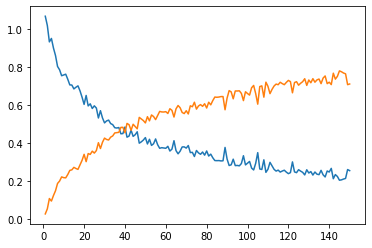

In [15]:
plt.plot([i+1 for i in range(epochs)],trainLoss)
plt.plot([i+1 for i in range(epochs)], sanityAccc)
checkpoint = {
            'epoch': epoch + 1,
            'loss': runningLoss,
            'state_dict': Model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'accuracy' : sanityAcc,
        }
save_ckp(checkpoint, True, PATH, bestPATH)

Testing Model:
==

In [16]:
Model, optimizer, epoch, loss, acc = load_ckp(bestPATH,Model,optimizer) #use bestPATH with name test, and don't overwrite it via above script
Model.eval()
i = 0
for inputs in tqdm(test_dataLoader):
    i+=1
    outputs = Model(inputs)
    outputs = torchvision.transforms.Resize((750,750))(outputs).cpu().detach().numpy().reshape((750,750))
    plt.imshow(outputs)
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    print("Index "+str(i)+": ")
    plt.show()

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "encoder1.enc1conv1.weight", "encoder1.enc1norm1.weight", "encoder1.enc1norm1.bias", "encoder1.enc1norm1.running_mean", "encoder1.enc1norm1.running_var", "encoder1.enc1conv2.weight", "encoder1.enc1norm2.weight", "encoder1.enc1norm2.bias", "encoder1.enc1norm2.running_mean", "encoder1.enc1norm2.running_var", "encoder2.enc2conv1.weight", "encoder2.enc2norm1.weight", "encoder2.enc2norm1.bias", "encoder2.enc2norm1.running_mean", "encoder2.enc2norm1.running_var", "encoder2.enc2conv2.weight", "encoder2.enc2norm2.weight", "encoder2.enc2norm2.bias", "encoder2.enc2norm2.running_mean", "encoder2.enc2norm2.running_var", "encoder3.enc3conv1.weight", "encoder3.enc3norm1.weight", "encoder3.enc3norm1.bias", "encoder3.enc3norm1.running_mean", "encoder3.enc3norm1.running_var", "encoder3.enc3conv2.weight", "encoder3.enc3norm2.weight", "encoder3.enc3norm2.bias", "encoder3.enc3norm2.running_mean", "encoder3.enc3norm2.running_var", "encoder4.enc4conv1.weight", "encoder4.enc4norm1.weight", "encoder4.enc4norm1.bias", "encoder4.enc4norm1.running_mean", "encoder4.enc4norm1.running_var", "encoder4.enc4conv2.weight", "encoder4.enc4norm2.weight", "encoder4.enc4norm2.bias", "encoder4.enc4norm2.running_mean", "encoder4.enc4norm2.running_var", "bottleneck.bottleneckconv1.weight", "bottleneck.bottlenecknorm1.weight", "bottleneck.bottlenecknorm1.bias", "bottleneck.bottlenecknorm1.running_mean", "bottleneck.bottlenecknorm1.running_var", "bottleneck.bottleneckconv2.weight", "bottleneck.bottlenecknorm2.weight", "bottleneck.bottlenecknorm2.bias", "bottleneck.bottlenecknorm2.running_mean", "bottleneck.bottlenecknorm2.running_var", "upconv4.weight", "upconv4.bias", "decoder4.dec4conv1.weight", "decoder4.dec4norm1.weight", "decoder4.dec4norm1.bias", "decoder4.dec4norm1.running_mean", "decoder4.dec4norm1.running_var", "decoder4.dec4conv2.weight", "decoder4.dec4norm2.weight", "decoder4.dec4norm2.bias", "decoder4.dec4norm2.running_mean", "decoder4.dec4norm2.running_var", "upconv3.weight", "upconv3.bias", "decoder3.dec3conv1.weight", "decoder3.dec3norm1.weight", "decoder3.dec3norm1.bias", "decoder3.dec3norm1.running_mean", "decoder3.dec3norm1.running_var", "decoder3.dec3conv2.weight", "decoder3.dec3norm2.weight", "decoder3.dec3norm2.bias", "decoder3.dec3norm2.running_mean", "decoder3.dec3norm2.running_var", "upconv2.weight", "upconv2.bias", "decoder2.dec2conv1.weight", "decoder2.dec2norm1.weight", "decoder2.dec2norm1.bias", "decoder2.dec2norm1.running_mean", "decoder2.dec2norm1.running_var", "decoder2.dec2conv2.weight", "decoder2.dec2norm2.weight", "decoder2.dec2norm2.bias", "decoder2.dec2norm2.running_mean", "decoder2.dec2norm2.running_var", "upconv1.weight", "upconv1.bias", "decoder1.dec1conv1.weight", "decoder1.dec1norm1.weight", "decoder1.dec1norm1.bias", "decoder1.dec1norm1.running_mean", "decoder1.dec1norm1.running_var", "decoder1.dec1conv2.weight", "decoder1.dec1norm2.weight", "decoder1.dec1norm2.bias", "decoder1.dec1norm2.running_mean", "decoder1.dec1norm2.running_var", "conv.weight", "conv.bias". 
	Unexpected key(s) in state_dict: "module.encoder1.enc1conv1.weight", "module.encoder1.enc1norm1.weight", "module.encoder1.enc1norm1.bias", "module.encoder1.enc1norm1.running_mean", "module.encoder1.enc1norm1.running_var", "module.encoder1.enc1norm1.num_batches_tracked", "module.encoder1.enc1conv2.weight", "module.encoder1.enc1norm2.weight", "module.encoder1.enc1norm2.bias", "module.encoder1.enc1norm2.running_mean", "module.encoder1.enc1norm2.running_var", "module.encoder1.enc1norm2.num_batches_tracked", "module.encoder2.enc2conv1.weight", "module.encoder2.enc2norm1.weight", "module.encoder2.enc2norm1.bias", "module.encoder2.enc2norm1.running_mean", "module.encoder2.enc2norm1.running_var", "module.encoder2.enc2norm1.num_batches_tracked", "module.encoder2.enc2conv2.weight", "module.encoder2.enc2norm2.weight", "module.encoder2.enc2norm2.bias", "module.encoder2.enc2norm2.running_mean", "module.encoder2.enc2norm2.running_var", "module.encoder2.enc2norm2.num_batches_tracked", "module.encoder3.enc3conv1.weight", "module.encoder3.enc3norm1.weight", "module.encoder3.enc3norm1.bias", "module.encoder3.enc3norm1.running_mean", "module.encoder3.enc3norm1.running_var", "module.encoder3.enc3norm1.num_batches_tracked", "module.encoder3.enc3conv2.weight", "module.encoder3.enc3norm2.weight", "module.encoder3.enc3norm2.bias", "module.encoder3.enc3norm2.running_mean", "module.encoder3.enc3norm2.running_var", "module.encoder3.enc3norm2.num_batches_tracked", "module.encoder4.enc4conv1.weight", "module.encoder4.enc4norm1.weight", "module.encoder4.enc4norm1.bias", "module.encoder4.enc4norm1.running_mean", "module.encoder4.enc4norm1.running_var", "module.encoder4.enc4norm1.num_batches_tracked", "module.encoder4.enc4conv2.weight", "module.encoder4.enc4norm2.weight", "module.encoder4.enc4norm2.bias", "module.encoder4.enc4norm2.running_mean", "module.encoder4.enc4norm2.running_var", "module.encoder4.enc4norm2.num_batches_tracked", "module.bottleneck.bottleneckconv1.weight", "module.bottleneck.bottlenecknorm1.weight", "module.bottleneck.bottlenecknorm1.bias", "module.bottleneck.bottlenecknorm1.running_mean", "module.bottleneck.bottlenecknorm1.running_var", "module.bottleneck.bottlenecknorm1.num_batches_tracked", "module.bottleneck.bottleneckconv2.weight", "module.bottleneck.bottlenecknorm2.weight", "module.bottleneck.bottlenecknorm2.bias", "module.bottleneck.bottlenecknorm2.running_mean", "module.bottleneck.bottlenecknorm2.running_var", "module.bottleneck.bottlenecknorm2.num_batches_tracked", "module.upconv4.weight", "module.upconv4.bias", "module.decoder4.dec4conv1.weight", "module.decoder4.dec4norm1.weight", "module.decoder4.dec4norm1.bias", "module.decoder4.dec4norm1.running_mean", "module.decoder4.dec4norm1.running_var", "module.decoder4.dec4norm1.num_batches_tracked", "module.decoder4.dec4conv2.weight", "module.decoder4.dec4norm2.weight", "module.decoder4.dec4norm2.bias", "module.decoder4.dec4norm2.running_mean", "module.decoder4.dec4norm2.running_var", "module.decoder4.dec4norm2.num_batches_tracked", "module.upconv3.weight", "module.upconv3.bias", "module.decoder3.dec3conv1.weight", "module.decoder3.dec3norm1.weight", "module.decoder3.dec3norm1.bias", "module.decoder3.dec3norm1.running_mean", "module.decoder3.dec3norm1.running_var", "module.decoder3.dec3norm1.num_batches_tracked", "module.decoder3.dec3conv2.weight", "module.decoder3.dec3norm2.weight", "module.decoder3.dec3norm2.bias", "module.decoder3.dec3norm2.running_mean", "module.decoder3.dec3norm2.running_var", "module.decoder3.dec3norm2.num_batches_tracked", "module.upconv2.weight", "module.upconv2.bias", "module.decoder2.dec2conv1.weight", "module.decoder2.dec2norm1.weight", "module.decoder2.dec2norm1.bias", "module.decoder2.dec2norm1.running_mean", "module.decoder2.dec2norm1.running_var", "module.decoder2.dec2norm1.num_batches_tracked", "module.decoder2.dec2conv2.weight", "module.decoder2.dec2norm2.weight", "module.decoder2.dec2norm2.bias", "module.decoder2.dec2norm2.running_mean", "module.decoder2.dec2norm2.running_var", "module.decoder2.dec2norm2.num_batches_tracked", "module.upconv1.weight", "module.upconv1.bias", "module.decoder1.dec1conv1.weight", "module.decoder1.dec1norm1.weight", "module.decoder1.dec1norm1.bias", "module.decoder1.dec1norm1.running_mean", "module.decoder1.dec1norm1.running_var", "module.decoder1.dec1norm1.num_batches_tracked", "module.decoder1.dec1conv2.weight", "module.decoder1.dec1norm2.weight", "module.decoder1.dec1norm2.bias", "module.decoder1.dec1norm2.running_mean", "module.decoder1.dec1norm2.running_var", "module.decoder1.dec1norm2.num_batches_tracked", "module.conv.weight", "module.conv.bias". 